# Workflow Outline
This notebook is used to conduct first round of experiment. 

First we train with Children's story dataset (categorical) to obtain baseline.

Then we train with Children's story combined with Emobank to get some results

## Install & Import modules

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.9 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import transformers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## Import data

In [3]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

## Set up data pipeline

In [4]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
EBAT_filename = "EmoBank_AffectiveText.csv"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))
df = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EBAT_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
df_children.head()

Children story dataset: 1207
Emobank dataset: 9814


,Unnamed: 0,sentence,label
0,0,"He looked around on every side and exclaimed, ...",4
1,1,"Then he got up and clambered out of the cave, ...",3
2,2,"""Alas, thou canst not help me.""",3
3,3,"They leapt nimbly upstairs and downstairs, and...",2
4,4,"Then she opened the door of the small house, a...",2


In [5]:
# some global variables 
# EKMAN_EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
# EKMAN_MAP = {'H': 'joy', 'N': 'neutral', 'F': 'fear', 'A': 'anger', 'S': 'surprise', 'Sa': 'sadness', 'D': 'disgust'}
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
NUM_CLASSES_EKMAN = 5
VAD_EMOTIONS = ['V', 'A', 'D']

EMOTION_NAMES = ['Ekman', 'VAD']
EMOTION_DIMS = [1, 3] # output dims

# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])


He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]


In [6]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

encoded_input = tokenizer(x_ekman_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']

encoded_input = tokenizer(x_vad_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']

y_ekman_tensor = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
vad_placeholder = torch.zeros((len(y_ekman_tensor), EMOTION_DIMS[1]), )
y_ekman_tensor = torch.concatenate((y_ekman_tensor, vad_placeholder), dim=-1)

y_vad_tensor = torch.tensor(y_vad_raw, dtype=torch.float)
ekman_placeholder = torch.zeros((len(y_vad_tensor), EMOTION_DIMS[0]), )
y_vad_tensor = torch.concatenate((ekman_placeholder, y_vad_tensor), dim=-1)

# optional: delete df and x_text if the dataset is large

In [7]:
print(X_ekman_input.shape)
print(X_vad_input.shape)

torch.Size([1207, 155])
torch.Size([9814, 155])


In [8]:
# Normalizing y (subject to change)
y_vad_tensor = F.normalize(y_vad_tensor, dim=-1)

### Train-val-test split

* split ekman dataset into 80-10-10
* split vad dataset into 80-10-10


In [9]:
def train_val_split(X_ids, X_mask, y, ratio):
  n = X_ids.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_ids_train, X_mask_train, y_train = X_ids[perm[:train_size]], X_mask[perm[:train_size]], y[perm[:train_size]]
  X_ids_val, X_mask_val, y_val = X_ids[perm[train_size:]], X_mask[perm[train_size:]], y[perm[train_size:]]

  return X_ids_train, X_mask_train, y_train, X_ids_val, X_mask_val, y_val

In [10]:
# split into train-test
X_ekman_ids_trainval, X_ekman_mask_trainval, y_ekman_trainval, X_ekman_ids_test, X_ekman_mask_test, y_ekman_test = train_val_split(X_ekman_input, X_ekman_mask, y_ekman_tensor, ratio=0.9)
X_ekman_ids_train, X_ekman_mask_train, y_ekman_train, X_ekman_ids_val, X_ekman_mask_val, y_ekman_val = train_val_split(X_ekman_ids_trainval, X_ekman_mask_trainval, y_ekman_trainval, ratio=8/9)

X_vad_ids_trainval, X_vad_mask_trainval, y_vad_trainval, X_vad_ids_test, X_vad_mask_test, y_vad_test = train_val_split(X_vad_input, X_vad_mask, y_vad_tensor, ratio=0.9)
X_vad_ids_train, X_vad_mask_train, y_vad_train, X_vad_ids_val, X_vad_mask_val, y_vad_val = train_val_split(X_vad_ids_trainval, X_vad_mask_trainval, y_vad_trainval, ratio=8/9)


In [11]:
print(f'number of ekman training points: {len(X_ekman_ids_train)}')
print(f'number of ekman validation points: {len(X_ekman_ids_val)}')
print(f'number of ekman testing points: {len(X_ekman_ids_test)}')
print(f'number of vad training points: {len(X_vad_ids_train)}')
print(f'number of vad validation points: {len(X_vad_ids_val)}')
print(f'number of vad testing points: {len(X_vad_ids_test)}')

number of ekman training points: 965
number of ekman validation points: 121
number of ekman testing points: 121
number of vad training points: 7850
number of vad validation points: 982
number of vad testing points: 982


In [12]:
# attach task labels to the two tasks 
task_ekman_train = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_train), 1))
task_ekman_val = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_val), 1))
task_ekman_test = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_test), 1))

task_vad_train = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_train), 1))
task_vad_val = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_val), 1))
task_vad_test = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_test), 1))

# Example
id = 600
# print(X_ids_train[id])
# print(X_mask_train[id])
print(y_ekman_train[id])
print(task_ekman_train[id])

tensor([4., 0., 0., 0.])
tensor([1, 0])


In [13]:
# Move everything to device
X_ekman_ids_train = X_ekman_ids_train.to(DEVICE)
X_ekman_mask_train = X_ekman_mask_train.to(DEVICE)
y_ekman_train = y_ekman_train.to(DEVICE)
task_ekman_train = task_ekman_train.to(DEVICE)

X_ekman_ids_val = X_ekman_ids_val.to(DEVICE)
X_ekman_mask_val = X_ekman_mask_val.to(DEVICE)
y_ekman_val = y_ekman_val.to(DEVICE)
task_ekman_val = task_ekman_val.to(DEVICE)

X_ekman_ids_test = X_ekman_ids_test.to(DEVICE)
X_ekman_mask_test = X_ekman_mask_test.to(DEVICE)
y_ekman_test = y_ekman_test.to(DEVICE)
task_ekman_test = task_ekman_test.to(DEVICE)

X_vad_ids_train = X_vad_ids_train.to(DEVICE)
X_vad_mask_train = X_vad_mask_train.to(DEVICE)
y_vad_train = y_vad_train.to(DEVICE)
task_vad_train = task_vad_train.to(DEVICE)

X_vad_ids_val = X_vad_ids_val.to(DEVICE)
X_vad_mask_val = X_vad_mask_val.to(DEVICE)
y_vad_val = y_vad_val.to(DEVICE)
task_vad_val = task_vad_val.to(DEVICE)

X_vad_ids_test = X_vad_ids_test.to(DEVICE)
X_vad_mask_test = X_vad_mask_test.to(DEVICE)
y_vad_test = y_vad_test.to(DEVICE)
task_vad_test = task_vad_test.to(DEVICE)

X_combined_ids_train = torch.concatenate((X_ekman_ids_train, X_vad_ids_train), dim=0)
X_combined_mask_train = torch.concatenate((X_ekman_mask_train, X_vad_mask_train), dim=0)
y_combined_train = torch.concatenate((y_ekman_train, y_vad_train), dim=0)
task_combined_train = torch.concatenate((task_ekman_train, task_vad_train), dim=0)

X_combined_ids_val = torch.concatenate((X_ekman_ids_val, X_vad_ids_val), dim=0)
X_combined_mask_val = torch.concatenate((X_ekman_mask_val, X_vad_mask_val), dim=0)
y_combined_val = torch.concatenate((y_ekman_val, y_vad_val), dim=0)
task_combined_val = torch.concatenate((task_ekman_val, task_vad_val), dim=0)

X_combined_ids_test = torch.concatenate((X_ekman_ids_test, X_vad_ids_test), dim=0)
X_combined_mask_test = torch.concatenate((X_ekman_mask_test, X_vad_mask_test), dim=0)
y_combined_test = torch.concatenate((y_ekman_test, y_vad_test), dim=0)
task_combined_test = torch.concatenate((task_ekman_test, task_vad_test), dim=0)

### Dataset

In [14]:
class EBAT_dataset(Dataset):
  def __init__(self, X_ids, X_mask, y, task, transform=None):
    self.X_ids = X_ids 
    self.X_mask = X_mask
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]
    self.transform = transform

  def __len__(self):
    return self.X_ids.shape[0]

  def __getitem__(self, idx):
    sample = (self.X_ids[idx], self.X_mask[idx], self.y[idx], self.task[idx])
    if self.transform:
        sample = self.transform(sample)
    return sample


In [15]:
ekman_train_dataset = EBAT_dataset(X_ekman_ids_train, X_ekman_mask_train, y_ekman_train, task_ekman_train)
ekman_val_dataset = EBAT_dataset(X_ekman_ids_val, X_ekman_mask_val, y_ekman_val, task_ekman_val)
ekman_test_dataset = EBAT_dataset(X_ekman_ids_test, X_ekman_mask_test, y_ekman_test, task_ekman_test)

vad_train_dataset = EBAT_dataset(X_vad_ids_train, X_vad_mask_train, y_vad_train, task_vad_train)
vad_val_dataset = EBAT_dataset(X_vad_ids_val, X_vad_mask_val, y_vad_val, task_vad_val)
vad_test_dataset = EBAT_dataset(X_vad_ids_test, X_vad_mask_test, y_vad_test, task_vad_test)

combined_train_dataset = EBAT_dataset(X_combined_ids_train, X_combined_mask_train, y_combined_train, task_combined_train)
combined_val_dataset = EBAT_dataset(X_combined_ids_val, X_combined_mask_val, y_combined_val, task_combined_val)
combined_test_dataset = EBAT_dataset(X_combined_ids_test, X_combined_mask_test, y_combined_test, task_combined_test)

dataset = {
    'ekman': {
        'train': ekman_train_dataset,
        'val': ekman_val_dataset,
        'test': ekman_test_dataset,
    },
    'vad': {
        'train': vad_train_dataset,
        'val': vad_val_dataset,
        'test': vad_test_dataset,
    },
    'combined': {
        'train': combined_train_dataset,
        'val': combined_val_dataset,
        'test': combined_test_dataset,
    }
}

### DataLoader

In [16]:
ekman_train_dataloader = DataLoader(dataset['ekman']['train'], batch_size = 30, shuffle=True)
ekman_val_dataloader = DataLoader(dataset['ekman']['val'], batch_size = 30, shuffle=True)
ekman_test_dataloader = DataLoader(dataset['ekman']['test'], batch_size = 30, shuffle=True)

vad_train_dataloader = DataLoader(dataset['vad']['train'], batch_size = 50, shuffle=True)
vad_val_dataloader = DataLoader(dataset['vad']['val'], batch_size = 50, shuffle=True)
vad_test_dataloader = DataLoader(dataset['vad']['test'], batch_size = 50, shuffle=True)

combined_train_dataloader = DataLoader(dataset['combined']['train'], batch_size = 50, shuffle=True)
combined_val_dataloader = DataLoader(dataset['combined']['val'], batch_size = 50, shuffle=True)
combined_test_dataloader = DataLoader(dataset['combined']['test'], batch_size = 50, shuffle=True)

dataloader = {
    'ekman': {
        'train': ekman_train_dataloader,
        'val': ekman_val_dataloader,
        'test': ekman_test_dataloader,
    },
    'vad': {
        'train': vad_train_dataloader,
        'val': vad_val_dataloader,
        'test': vad_test_dataloader,
    },
    'combined': {
        'train': combined_train_dataloader,
        'val': combined_val_dataloader,
        'test': combined_test_dataloader,
    }
}

print(f"number of batches in ekman training set: {len(dataloader['ekman']['train'])}")
print(f"number of batches in ekman val set: {len(dataloader['ekman']['val'])}")
print(f"number of batches in ekman val set: {len(dataloader['ekman']['test'])}")

# example batch
sample = next(iter(dataloader['combined']['train']))
X_id, X_mask, y, task = sample

# example single data
print(X_id[0])
print(X_mask[0])
print(y[0])
print(task[0])

number of batches in ekman training set: 33
number of batches in ekman val set: 5
number of batches in ekman val set: 5
tensor([  101, 15925,  4402,  2075,  1999,  4291,  4290,  4627,  2012,  2712,
         2504,  2007,  1996,  4372,  2705,  7941,  2989,  2300,  4026,  1517,
         1037,  4666,  1997, 27945,  2015,  1010, 20157,  1010, 29306,  1010,
        18015,  2015,  1010,  1998, 12187,  2015,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0, 

## Model Definition

In [17]:
class MultiheadNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.shared_base = nn.Linear(768, 256)
    self.ekman_predictor = nn.Linear(256, NUM_CLASSES_EKMAN)
    self.vad_predictor = nn.Linear(256, EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    pooler_output = self.relu(self.shared_base(pooler_output))

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(pooler_output)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(pooler_output)
    y_vad = self.relu(y_vad)

    y = torch.concat((y_ekman, y_vad), dim=1)

    return y

In [18]:
class SharedEmbeddingNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.predictor = nn.Linear(768, NUM_CLASSES_EKMAN+EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    # print(hidden_state.shape)
    # print(pooler_output.shape)
    # print(task[:, 0].shape)
    # print(task[:, 0].unsqueeze(-1).shape)
    y = self.predictor(pooler_output)
    ekman_filter = task[:, 0].unsqueeze(-1)
    vad_filter = task[:, 1].unsqueeze(-1)

    y[:, 0:5] = y[:, 0:5] * ekman_filter
    y[:, 5:] = y[:, 5:] * vad_filter

    y = self.relu(y)

    return y

In [19]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
net = MultiheadNetwork(bert)
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [21]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[196608, 256, 1280, 5, 768, 3]


In [22]:
with torch.no_grad():
  sample = next(iter(dataloader['combined']['train']))
  X_id, X_mask, y, task = sample

  y_pred = net(X_id, X_mask, task)

In [23]:
y_pred[:10]

tensor([[-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0494,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0928,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0587,  0.0000],
        [-1.6132, -1.5947, -1.5511, -1.5968, -1.6969,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0989,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0692,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0397,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0492,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0780,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.0000,  0.0446,  0.0000]],
       device='cuda:0')

### Loss Function

In [24]:
# class custom_MSE(object):
#   def __init__(self):
#     self.loss = nn.MSELoss()
#     pass
  
#   def __call__(self, y_gt, y_pred) -> torch.tensor:
#     '''
#     Computes MSE on all emotion labelling schemes

#     Returns:
#     -----
#     losses: 1D tensor with length num_schemes
#     '''
#     losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float)
#     s = 0
#     for (i, dim) in enumerate(EMOTION_DIMS):
#       losses[i] = self.loss(y_gt[:, s:s+dim], y_pred[:, s:s+dim]).mean()
#       s += dim
#     # avg_loss = torch.norm(losses)
#     return losses

class multiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss()
    self.vad_criterion = nn.MSELoss()
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    ekman_loss = self.ekman_criterion(y_pred[:, 0:5], y_gt[:, 0:1].squeeze(dim=1).to(int))* task[:, 0].unsqueeze(-1)
    losses[0] = ekman_loss.mean()

    # vad loss (MSE)
    vad_loss = self.vad_criterion(y_pred[:, 5:], y_gt[:, 1:]) * task[:, 1].unsqueeze(-1) * 100
    losses[1] = vad_loss.mean()

    return losses

## Training Manager

In [25]:
class TrainingManager():
  def __init__(self, net, dataloader, max_epochs=100):
    self.net = net
    self.dataloader = dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = multiTaskLoss()

    self.optimizer = torch.optim.Adam(self.net.parameters())

    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'val_loss_ekman': [],
        'val_loss_vad': [],
        'val_loss_avg': [],
        'val_ekman_accuracy': []
    }

    self.max_epochs = max_epochs
    self.num_epochs = 0
  
  def train(self, epochs, train_label='ekman', val_label='ekman'):
    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_avg = 0

      for X_id, X_mask, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X_id, X_mask, task)

        train_loss = self.criterion(y_pred, y, task)

        # count the number of samples
        ekman_count = task[:, 0].sum()
        vad_count = task[:, 1].sum()

        # rescale loss
        if ekman_count:
          train_loss[0] *= len(X_id) / ekman_count
        if vad_count:
          train_loss[1] *= len(X_id) / vad_count

        loss = train_loss.sum()

        loss.backward()

        self.optimizer.step()

        # storing minibatch results
        total_loss_ekman += train_loss[0].item()
        total_loss_vad += train_loss[1].item()
        total_loss_avg += torch.norm(train_loss).item()


      # storing epoch results
      val_loss_ekman, val_loss_vad, val_loss_avg, val_ekman_accuracy = self._evaluate(self.dataloader[val_label]['val'])

      total_loss_ekman /= len(self.dataloader[train_label]['train'])
      total_loss_vad /= len(self.dataloader[train_label]['train'])
      total_loss_avg /= len(self.dataloader[train_label]['train'])
    
      self.history['train_loss_ekman'].append(total_loss_ekman)
      self.history['train_loss_vad'].append(total_loss_vad)
      self.history['train_loss_avg'].append(total_loss_avg)
      self.history['val_loss_ekman'].append(val_loss_ekman)
      self.history['val_loss_vad'].append(val_loss_vad)
      self.history['val_loss_avg'].append(val_loss_avg)
      self.history['val_ekman_accuracy'].append(val_ekman_accuracy)

      print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {total_loss_ekman:.3f}, vad_loss = {total_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {val_loss_ekman:.3f}, vad_loss = {val_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_ekman_accuracy = {val_ekman_accuracy:.3f}')

      self.num_epochs += 1
  
  def _evaluate(self, dataloader=None):
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss_avg = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      for X_id, X_mask, y, task in tqdm(dataloader):
        y_pred = self.net(X_id, X_mask, task)
        loss = self.criterion(y_pred, y, task)

        # count the number of samples
        ekman_count = task[:, 0].sum()
        vad_count = task[:, 1].sum()

        # rescale loss
        if ekman_count:
          loss[0] *= len(X_id) / ekman_count
        if vad_count:
          loss[1] *= len(X_id) / vad_count

        y_top_gt = y[:, 0:1].to(int).squeeze(dim=-1)
        y_top_pred = torch.argmax(y_pred[:, 0:5], dim=-1)

        ekman_top1_correct += torch.where(y_top_gt == y_top_pred, torch.ones_like(y_top_gt), torch.zeros_like(y_top_gt)).sum()

        total_loss_ekman += loss[0].item()
        total_loss_vad += loss[1].item()
        total_loss_avg += loss.sum().item()
    
    total_loss_ekman /= len(dataloader)
    total_loss_vad /= len(dataloader)
    total_loss_avg /= len(dataloader)
    ekman_accuracy = ekman_top1_correct.item() / len(dataloader.dataset)

    return total_loss_ekman, total_loss_vad, total_loss_avg, ekman_accuracy

  def evaluate(self, label='ekman'):
    loss, _, _, acc = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Loss = {loss:.3f}')
    print(f'Accuracy = {acc * 100:.2f}')

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Avg loss')
    plt.plot(self.history['train_loss_avg'], label='train')
    plt.plot(self.history['val_loss_avg'], label='val')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Ekman Loss')
    plt.plot(self.history['train_loss_ekman'], label='train')
    plt.plot(self.history['val_loss_ekman'], label='val')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('VAD Loss')
    plt.plot(self.history['train_loss_vad'], label='train')
    plt.plot(self.history['val_loss_vad'], label='val')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('Ekman top1 Accuracy')
    plt.plot(self.history['val_ekman_accuracy'], label='val')
    plt.legend()

    plt.show()


In [26]:
criterion = multiTaskLoss()
X_id, X_mask, y, task = next(iter(dataloader['vad']['train']))
with torch.no_grad():
  y_pred = net2(X_id, X_mask, task)
  loss = criterion(y_pred, y, task)
print(loss)
# count the number of samples
ekman_count = task[:, 0].sum()
vad_count = task[:, 1].sum()
print(ekman_count)
print(vad_count)

print(y[0])
print(y_pred[0])

NameError: ignored

## Training

In [35]:
net = MultiheadNetwork(bert)
net.to(DEVICE)
training_manager_multi = TrainingManager(net, dataloader)

In [39]:
training_manager_multi.evaluate()

  0%|          | 0/5 [00:00<?, ?it/s]

TEST SET (ekman)
Loss = 0.727
Accuracy = 68.60


In [37]:
training_manager_multi.train(epochs=30, train_label='ekman', val_label='ekman')

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.519
Epoch 1: ekman_loss = 1.519, vad_loss = 0.000
Epoch 1: val_avg_loss = 1.595
Epoch 1: ekman_loss = 1.595, vad_loss = 0.000
Epoch 1: val_ekman_accuracy = 0.430


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.459
Epoch 2: ekman_loss = 1.459, vad_loss = 0.000
Epoch 2: val_avg_loss = 1.515
Epoch 2: ekman_loss = 1.515, vad_loss = 0.000
Epoch 2: val_ekman_accuracy = 0.322


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.389
Epoch 3: ekman_loss = 1.389, vad_loss = 0.000
Epoch 3: val_avg_loss = 1.447
Epoch 3: ekman_loss = 1.447, vad_loss = 0.000
Epoch 3: val_ekman_accuracy = 0.545


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.336
Epoch 4: ekman_loss = 1.336, vad_loss = 0.000
Epoch 4: val_avg_loss = 1.685
Epoch 4: ekman_loss = 1.685, vad_loss = 0.000
Epoch 4: val_ekman_accuracy = 0.421


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.314
Epoch 5: ekman_loss = 1.314, vad_loss = 0.000
Epoch 5: val_avg_loss = 1.155
Epoch 5: ekman_loss = 1.155, vad_loss = 0.000
Epoch 5: val_ekman_accuracy = 0.488


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.229
Epoch 6: ekman_loss = 1.229, vad_loss = 0.000
Epoch 6: val_avg_loss = 1.214
Epoch 6: ekman_loss = 1.214, vad_loss = 0.000
Epoch 6: val_ekman_accuracy = 0.554


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.182
Epoch 7: ekman_loss = 1.182, vad_loss = 0.000
Epoch 7: val_avg_loss = 1.267
Epoch 7: ekman_loss = 1.267, vad_loss = 0.000
Epoch 7: val_ekman_accuracy = 0.455


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.162
Epoch 8: ekman_loss = 1.162, vad_loss = 0.000
Epoch 8: val_avg_loss = 0.950
Epoch 8: ekman_loss = 0.950, vad_loss = 0.000
Epoch 8: val_ekman_accuracy = 0.620


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.162
Epoch 9: ekman_loss = 1.162, vad_loss = 0.000
Epoch 9: val_avg_loss = 1.208
Epoch 9: ekman_loss = 1.208, vad_loss = 0.000
Epoch 9: val_ekman_accuracy = 0.612


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.102
Epoch 10: ekman_loss = 1.102, vad_loss = 0.000
Epoch 10: val_avg_loss = 1.284
Epoch 10: ekman_loss = 1.284, vad_loss = 0.000
Epoch 10: val_ekman_accuracy = 0.496


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.096
Epoch 11: ekman_loss = 1.096, vad_loss = 0.000
Epoch 11: val_avg_loss = 1.265
Epoch 11: ekman_loss = 1.265, vad_loss = 0.000
Epoch 11: val_ekman_accuracy = 0.620


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.045
Epoch 12: ekman_loss = 1.045, vad_loss = 0.000
Epoch 12: val_avg_loss = 0.872
Epoch 12: ekman_loss = 0.872, vad_loss = 0.000
Epoch 12: val_ekman_accuracy = 0.653


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 0.968
Epoch 13: ekman_loss = 0.968, vad_loss = 0.000
Epoch 13: val_avg_loss = 1.117
Epoch 13: ekman_loss = 1.117, vad_loss = 0.000
Epoch 13: val_ekman_accuracy = 0.661


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.003
Epoch 14: ekman_loss = 1.003, vad_loss = 0.000
Epoch 14: val_avg_loss = 1.036
Epoch 14: ekman_loss = 1.036, vad_loss = 0.000
Epoch 14: val_ekman_accuracy = 0.504


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 0.952
Epoch 15: ekman_loss = 0.952, vad_loss = 0.000
Epoch 15: val_avg_loss = 1.429
Epoch 15: ekman_loss = 1.429, vad_loss = 0.000
Epoch 15: val_ekman_accuracy = 0.669


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 0.961
Epoch 16: ekman_loss = 0.961, vad_loss = 0.000
Epoch 16: val_avg_loss = 0.960
Epoch 16: ekman_loss = 0.960, vad_loss = 0.000
Epoch 16: val_ekman_accuracy = 0.686


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 0.913
Epoch 17: ekman_loss = 0.913, vad_loss = 0.000
Epoch 17: val_avg_loss = 1.437
Epoch 17: ekman_loss = 1.437, vad_loss = 0.000
Epoch 17: val_ekman_accuracy = 0.669


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 0.937
Epoch 18: ekman_loss = 0.937, vad_loss = 0.000
Epoch 18: val_avg_loss = 0.828
Epoch 18: ekman_loss = 0.828, vad_loss = 0.000
Epoch 18: val_ekman_accuracy = 0.669


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 0.888
Epoch 19: ekman_loss = 0.888, vad_loss = 0.000
Epoch 19: val_avg_loss = 0.887
Epoch 19: ekman_loss = 0.887, vad_loss = 0.000
Epoch 19: val_ekman_accuracy = 0.694


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 0.852
Epoch 20: ekman_loss = 0.852, vad_loss = 0.000
Epoch 20: val_avg_loss = 0.779
Epoch 20: ekman_loss = 0.779, vad_loss = 0.000
Epoch 20: val_ekman_accuracy = 0.620


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 0.880
Epoch 21: ekman_loss = 0.880, vad_loss = 0.000
Epoch 21: val_avg_loss = 0.885
Epoch 21: ekman_loss = 0.885, vad_loss = 0.000
Epoch 21: val_ekman_accuracy = 0.702


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.904
Epoch 22: ekman_loss = 0.904, vad_loss = 0.000
Epoch 22: val_avg_loss = 0.909
Epoch 22: ekman_loss = 0.909, vad_loss = 0.000
Epoch 22: val_ekman_accuracy = 0.678


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 0.893
Epoch 23: ekman_loss = 0.893, vad_loss = 0.000
Epoch 23: val_avg_loss = 0.988
Epoch 23: ekman_loss = 0.988, vad_loss = 0.000
Epoch 23: val_ekman_accuracy = 0.636


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.853
Epoch 24: ekman_loss = 0.853, vad_loss = 0.000
Epoch 24: val_avg_loss = 0.997
Epoch 24: ekman_loss = 0.997, vad_loss = 0.000
Epoch 24: val_ekman_accuracy = 0.669


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.854
Epoch 25: ekman_loss = 0.854, vad_loss = 0.000
Epoch 25: val_avg_loss = 1.015
Epoch 25: ekman_loss = 1.015, vad_loss = 0.000
Epoch 25: val_ekman_accuracy = 0.653


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.856
Epoch 26: ekman_loss = 0.856, vad_loss = 0.000
Epoch 26: val_avg_loss = 0.802
Epoch 26: ekman_loss = 0.802, vad_loss = 0.000
Epoch 26: val_ekman_accuracy = 0.620


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.930
Epoch 27: ekman_loss = 0.930, vad_loss = 0.000
Epoch 27: val_avg_loss = 0.857
Epoch 27: ekman_loss = 0.857, vad_loss = 0.000
Epoch 27: val_ekman_accuracy = 0.628


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.824
Epoch 28: ekman_loss = 0.824, vad_loss = 0.000
Epoch 28: val_avg_loss = 0.724
Epoch 28: ekman_loss = 0.724, vad_loss = 0.000
Epoch 28: val_ekman_accuracy = 0.686


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.768
Epoch 29: ekman_loss = 0.768, vad_loss = 0.000
Epoch 29: val_avg_loss = 0.838
Epoch 29: ekman_loss = 0.838, vad_loss = 0.000
Epoch 29: val_ekman_accuracy = 0.636


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.771
Epoch 30: ekman_loss = 0.771, vad_loss = 0.000
Epoch 30: val_avg_loss = 1.058
Epoch 30: ekman_loss = 1.058, vad_loss = 0.000
Epoch 30: val_ekman_accuracy = 0.678


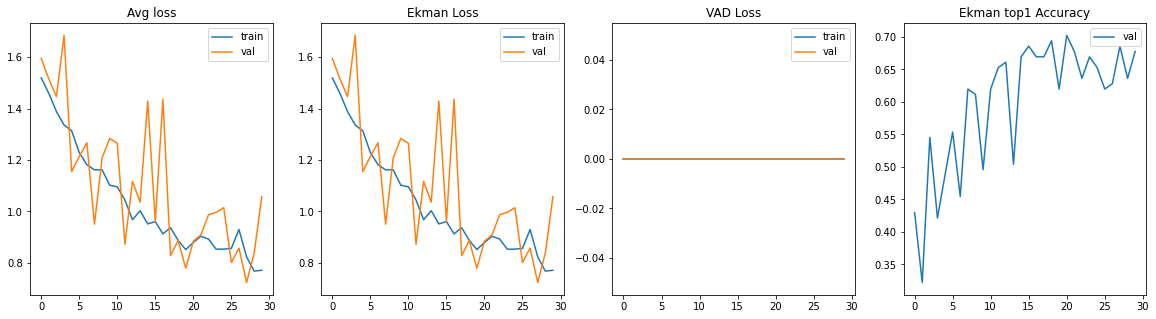

In [38]:
training_manager_multi.plot_history()

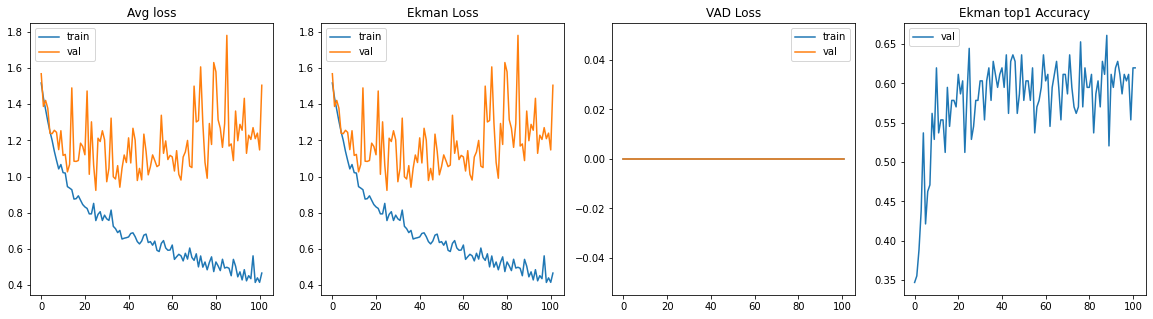

In [ ]:
training_manager_multi.plot_history()

In [27]:
net2 = MultiheadNetwork(bert)
net2.to(DEVICE)
training_manager_multi_combined = TrainingManager(net2, dataloader)

In [40]:
training_manager_multi_combined.evaluate(label='ekman')

  0%|          | 0/5 [00:00<?, ?it/s]

TEST SET (ekman)
Loss = 0.905
Accuracy = 63.64


In [33]:
training_manager_multi_combined.train(epochs=20, train_label='combined', val_label='ekman')

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.583
Epoch 1: ekman_loss = 1.579, vad_loss = 0.113
Epoch 1: val_avg_loss = 1.196
Epoch 1: ekman_loss = 1.196, vad_loss = 0.000
Epoch 1: val_ekman_accuracy = 0.471


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.580
Epoch 2: ekman_loss = 1.576, vad_loss = 0.111
Epoch 2: val_avg_loss = 1.180
Epoch 2: ekman_loss = 1.180, vad_loss = 0.000
Epoch 2: val_ekman_accuracy = 0.537


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.578
Epoch 3: ekman_loss = 1.574, vad_loss = 0.117
Epoch 3: val_avg_loss = 1.165
Epoch 3: ekman_loss = 1.165, vad_loss = 0.000
Epoch 3: val_ekman_accuracy = 0.587


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.573
Epoch 4: ekman_loss = 1.569, vad_loss = 0.113
Epoch 4: val_avg_loss = 1.156
Epoch 4: ekman_loss = 1.156, vad_loss = 0.000
Epoch 4: val_ekman_accuracy = 0.529


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.562
Epoch 5: ekman_loss = 1.557, vad_loss = 0.113
Epoch 5: val_avg_loss = 1.321
Epoch 5: ekman_loss = 1.321, vad_loss = 0.000
Epoch 5: val_ekman_accuracy = 0.504


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.567
Epoch 6: ekman_loss = 1.562, vad_loss = 0.113
Epoch 6: val_avg_loss = 1.197
Epoch 6: ekman_loss = 1.197, vad_loss = 0.000
Epoch 6: val_ekman_accuracy = 0.587


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.564
Epoch 7: ekman_loss = 1.559, vad_loss = 0.112
Epoch 7: val_avg_loss = 1.200
Epoch 7: ekman_loss = 1.200, vad_loss = 0.000
Epoch 7: val_ekman_accuracy = 0.545


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.561
Epoch 8: ekman_loss = 1.557, vad_loss = 0.108
Epoch 8: val_avg_loss = 1.056
Epoch 8: ekman_loss = 1.056, vad_loss = 0.000
Epoch 8: val_ekman_accuracy = 0.636


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.559
Epoch 9: ekman_loss = 1.555, vad_loss = 0.109
Epoch 9: val_avg_loss = 1.171
Epoch 9: ekman_loss = 1.171, vad_loss = 0.000
Epoch 9: val_ekman_accuracy = 0.645


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.548
Epoch 10: ekman_loss = 1.543, vad_loss = 0.109
Epoch 10: val_avg_loss = 1.060
Epoch 10: ekman_loss = 1.060, vad_loss = 0.000
Epoch 10: val_ekman_accuracy = 0.645


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.545
Epoch 11: ekman_loss = 1.540, vad_loss = 0.108
Epoch 11: val_avg_loss = 0.930
Epoch 11: ekman_loss = 0.930, vad_loss = 0.000
Epoch 11: val_ekman_accuracy = 0.504


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.534
Epoch 12: ekman_loss = 1.528, vad_loss = 0.111
Epoch 12: val_avg_loss = 1.181
Epoch 12: ekman_loss = 1.181, vad_loss = 0.000
Epoch 12: val_ekman_accuracy = 0.669


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.550
Epoch 13: ekman_loss = 1.546, vad_loss = 0.109
Epoch 13: val_avg_loss = 1.105
Epoch 13: ekman_loss = 1.105, vad_loss = 0.000
Epoch 13: val_ekman_accuracy = 0.653


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.534
Epoch 14: ekman_loss = 1.529, vad_loss = 0.108
Epoch 14: val_avg_loss = 0.901
Epoch 14: ekman_loss = 0.901, vad_loss = 0.000
Epoch 14: val_ekman_accuracy = 0.628


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.521
Epoch 15: ekman_loss = 1.515, vad_loss = 0.107
Epoch 15: val_avg_loss = 0.861
Epoch 15: ekman_loss = 0.861, vad_loss = 0.000
Epoch 15: val_ekman_accuracy = 0.678


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.528
Epoch 16: ekman_loss = 1.523, vad_loss = 0.108
Epoch 16: val_avg_loss = 1.074
Epoch 16: ekman_loss = 1.074, vad_loss = 0.000
Epoch 16: val_ekman_accuracy = 0.678


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.539
Epoch 17: ekman_loss = 1.534, vad_loss = 0.112
Epoch 17: val_avg_loss = 0.939
Epoch 17: ekman_loss = 0.939, vad_loss = 0.000
Epoch 17: val_ekman_accuracy = 0.661


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.543
Epoch 18: ekman_loss = 1.538, vad_loss = 0.109
Epoch 18: val_avg_loss = 1.088
Epoch 18: ekman_loss = 1.088, vad_loss = 0.000
Epoch 18: val_ekman_accuracy = 0.628


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 1.532
Epoch 19: ekman_loss = 1.527, vad_loss = 0.107
Epoch 19: val_avg_loss = 1.152
Epoch 19: ekman_loss = 1.152, vad_loss = 0.000
Epoch 19: val_ekman_accuracy = 0.645


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.541
Epoch 20: ekman_loss = 1.537, vad_loss = 0.109
Epoch 20: val_avg_loss = 0.868
Epoch 20: ekman_loss = 0.868, vad_loss = 0.000
Epoch 20: val_ekman_accuracy = 0.694


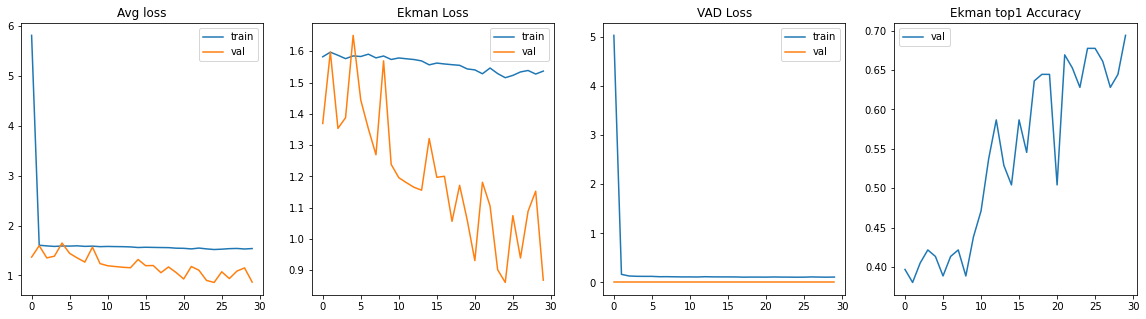

In [34]:
training_manager_multi_combined.plot_history()

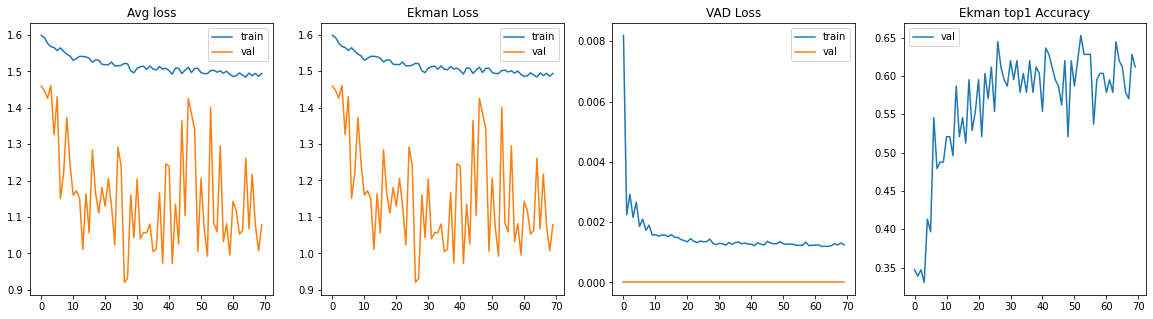

In [ ]:
training_manager_multi_combined.plot_history()

## Qualitative Evaluation

In [ ]:
results_df = pd.DataFrame([], columns = EKMAN_EMOTIONS + VAD_EMOTIONS)
NUM_EXAMPLES = 10
with torch.no_grad():
  sample = next(iter(dataloader['combined']['test']))
  X_id, X_mask, y, task = sample
  y_ekman = torch.nn.functional.one_hot(y[:, 0].to(int), num_classes = 5)
  y_display = torch.concatenate((y_ekman, y[:, 1:]), dim=-1)
  y_pred = net2(X_id, X_mask, task)
  
  for i in range(NUM_EXAMPLES):
    sent = tokenizer.decode(X_id[i], skip_special_tokens=True)
    row_gt = {heading: val for heading, val, in zip(results_df.columns,y_display[i].cpu().numpy())}
    row_pred = {heading: val for heading, val, in zip(results_df.columns, y_pred[i].cpu().numpy())}
    results_df = pd.concat((results_df, pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}'])))
    print(sent)
results_df

a short bus ride away is cheung sha beach, 3 km ( 2 miles ) long, and popular for its white sand and excellent facilities.
johnlopresti said... thought i would post a link with a cute title related to the post.
he was wearing a new jacket and snow boots, but he had on a hawaiian shirt underneath and khaki shorts of all things.
and our roots go deep.
sri lanka clashes kill 129 troops
i'm gonna take the plug out.
in return, we will recognize target as a sponsor during our event and in the event program.
experience the peace and beauty of coastal rhythms.
" the core of our strategy is to lead in technology and attack the high - performance segments of the market, " said john kelly, senior vice president in charge of ibm's technology group.
enclosures


,anger-disgust,fear,happy,sad,surprise,V,A,D
gt 0,1.000000,0.000000,0.000000,0.000000,0.000000,0.600444,0.554256,0.576426
pred 0,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.577078,0.554826,0.569422
gt 1,1.000000,0.000000,0.000000,0.000000,0.000000,0.667655,0.505799,0.546263
pred 1,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.576921,0.571002,0.580984
gt 2,1.000000,0.000000,0.000000,0.000000,0.000000,0.562718,0.562718,0.605555
pred 2,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.550031,0.586517,0.591497
gt 3,1.000000,0.000000,0.000000,0.000000,0.000000,0.564532,0.564532,0.602168
pred 3,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.606954,0.544989,0.574708
gt 4,1.000000,0.000000,0.000000,0.000000,0.000000,0.429548,0.751708,0.500423
pred 4,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.509981,0.664883,0.625027


In [ ]:
EKMAN_EMOTIONS

['anger-disgust', 'fear', 'happy', 'sad', 'surprise']